In [1]:
import warnings
from time import time

import cvxpy as cvx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame
from scipy.stats import rankdata
from sklearn.utils import check_random_state

warnings.filterwarnings("ignore")

In [2]:
def exam_func(n_doc: int, K: int, shape: str = "inv") -> np.ndarray:
    assert shape in ["inv", "exp", "log"]
    if shape == "inv":
        v = np.ones(K) / np.arange(1, K + 1)
    elif shape == "exp":
        v = 1.0 / np.exp(np.arange(K))

    return v[:, np.newaxis]


def evaluate_pi(pi: np.ndarray, rel_mat: np.ndarray, v: np.ndarray):
    n_query, n_doc = rel_mat.shape
    expo_mat = (pi * v.T).sum(2)
    click_mat = rel_mat * expo_mat
    user_util = click_mat.sum() / n_query
    item_utils = click_mat.sum(0) / n_query
    nsw = np.power(item_utils.prod(), 1 / n_doc)

    max_envies = np.zeros(n_doc)
    for i in range(n_doc):
        u_d_swap = (expo_mat * rel_mat[:, [i] * n_doc]).sum(0)
        d_envies = u_d_swap - u_d_swap[i]
        max_envies[i] = d_envies.max() / n_query

    return user_util, item_utils, max_envies, nsw


def compute_pi_max(
    rel_mat: np.ndarray,
    v: np.ndarray,
) -> np.ndarray:
    n_query, n_doc = rel_mat.shape
    K = v.shape[0]

    pi = np.zeros((n_query, n_doc, K))
    for k in np.arange(K):
        pi_at_k = np.zeros_like(rel_mat)
        pi_at_k[rankdata(-rel_mat, axis=1, method="ordinal") == k + 1] = 1
        pi[:, :, k] = pi_at_k

    return pi


def compute_pi_expo_fair(
    rel_mat: np.ndarray,
    v: np.ndarray,
) -> np.ndarray:
    n_query, n_doc = rel_mat.shape
    K = v.shape[0]
    query_basis = np.ones((n_query, 1))
    am_rel = rel_mat.sum(0)[:, np.newaxis]
    am_expo = v.sum() * n_query * am_rel / rel_mat.sum()

    pi = cvx.Variable((n_query, n_doc * K))
    obj = 0.0
    constraints = []
    for d in np.arange(n_doc):
        pi_d = pi[:, K * d : K * (d + 1)]
        obj += rel_mat[:, d] @ pi_d @ v
        # feasible allocation
        basis_ = np.zeros((n_doc * K, 1))
        basis_[K * d : K * (d + 1)] = 1
        constraints += [pi @ basis_ <= query_basis]
        # amortized exposure
        constraints += [query_basis.T @ pi_d @ v <= am_expo[d]]
    # feasible allocation
    for k in np.arange(K):
        basis_ = np.zeros((n_doc * K, 1))
        basis_[np.arange(n_doc) * K + k] = 1
        constraints += [pi @ basis_ <= query_basis]
    constraints += [pi <= 1.0]
    constraints += [0.0 <= pi]

    prob = cvx.Problem(cvx.Maximize(obj), constraints)
    prob.solve(solver=cvx.SCS)

    pi = pi.value.reshape((n_query, n_doc, K))
    pi = np.clip(pi, 0.0, 1.0)

    return pi


def compute_pi_nsw(
    rel_mat: np.ndarray,
    v: np.ndarray,
    alpha: float = 0.0,
) -> np.ndarray:
    n_query, n_doc = rel_mat.shape
    K = v.shape[0]
    query_basis = np.ones((n_query, 1))
    am_rel = rel_mat.sum(0) ** alpha

    pi = cvx.Variable((n_query, n_doc * K))
    obj = 0.0
    constraints = []
    for d in np.arange(n_doc):
        obj += am_rel[d] * cvx.log(rel_mat[:, d] @ pi[:, K * d : K * (d + 1)] @ v)
        # feasible allocation
        basis_ = np.zeros((n_doc * K, 1))
        basis_[K * d : K * (d + 1)] = 1
        constraints += [pi @ basis_ <= query_basis]
    # feasible allocation
    for k in np.arange(K):
        basis_ = np.zeros((n_doc * K, 1))
        basis_[np.arange(n_doc) * K + k] = 1
        constraints += [pi @ basis_ <= query_basis]
    constraints += [pi <= 1.0]
    constraints += [0.0 <= pi]

    prob = cvx.Problem(cvx.Maximize(obj), constraints)
    prob.solve(solver=cvx.SCS)

    pi = pi.value.reshape((n_query, n_doc, K))
    pi = np.clip(pi, 0.0, 1.0)

    return pi


def compute_pi_unif(rel_mat: np.ndarray, v: np.ndarray) -> np.ndarray:
    print(rel_mat.shape)
    n_query, n_doc = rel_mat.shape
    K = v.shape[0]

    return np.ones((n_query, n_doc, K)) / n_doc


In [23]:
def main(n_doc, K_list,n_seeds,alpha_list):
    start_time = time()

    # configurations
    pol_list = ["max", "expo-fair", "unif"]
    pol_list += [f"nsw_{alpha}" for alpha in alpha_list]
    result_df = DataFrame(
        columns=[
            "policy",
            "seed",
            "K",
            "user_util",
            "mean_max_envy",
            "pct_better_off",
            "pct_worse_off",
        ]
    )

    global ans
    elapsed_prev = 0.0
    for k in K_list:
        v = exam_func(n_doc, k, "inv")
        result_df_box = DataFrame(
            columns=["policy", "item_util", "max_envy", "imp_in_item_util"]
        )
        for s in np.arange(n_seeds):
            rel_mat_true = res[['true_rele_1','true_rele_2','true_rele_3','true_rele_4','true_rele_5',
                                'true_rele_6','true_rele_7','true_rele_8','true_rele_9','true_rele_10']].T.to_numpy()
            rel_mat_obs = res[['rele_1','rele_2','rele_3','rele_4','rele_5','rele_6','rele_7',
                               'rele_8','rele_9','rele_10']].T.to_numpy()

            # uniform
            pi_unif = compute_pi_unif(rel_mat=rel_mat_obs, v=v)
            user_util_unif, item_utils_unif, max_envies_unif, _ = evaluate_pi(
                pi=pi_unif,
                rel_mat=rel_mat_true,
                v=v,
            )

            # max
            pi_max = compute_pi_max(rel_mat=rel_mat_obs, v=v)
            user_util_max, item_utils_max, max_envies_max, _ = evaluate_pi(
                pi=pi_max,
                rel_mat=rel_mat_true,
                v=v,
            )
            result_max = DataFrame(
                data={
                    "policy": ["Max"] * rel_mat_true.shape[1],
                    "item_util": item_utils_max,
                    "max_envy": max_envies_max,
                    "imp_in_item_util": item_utils_max / item_utils_unif,
                }
            )
            result_df_box = pd.concat([result_df_box, result_max])

            # exposure-based fair
            pi_expo_fair = compute_pi_expo_fair(rel_mat=rel_mat_obs, v=v)
            user_util_expo, item_utils_expo, max_envies_expo, _ = evaluate_pi(
                pi=pi_expo_fair,
                rel_mat=rel_mat_true,
                v=v,
            )
            result_expo_fair = DataFrame(
                data={
                    "policy": ["Expo-Fair"] * rel_mat_true.shape[1],
                    "item_util": item_utils_expo,
                    "max_envy": max_envies_expo,
                    "imp_in_item_util": item_utils_expo / item_utils_unif,
                }
            )
            result_df_box = pd.concat([result_df_box, result_expo_fair])

            # nash social welfare
            user_util_nsw_list = []
            mean_max_envy_nsw_list = []
            pct_item_util_better_off_nsw_list = []
            pct_item_util_worse_off_nsw_list = []
            for alpha_ in alpha_list:
                pi_nsw = compute_pi_nsw(rel_mat=rel_mat_obs, v=v, alpha=alpha_)
                ans = pi_nsw
                user_util_nsw, item_utils_nsw, max_envies_nsw, _ = evaluate_pi(
                    pi=pi_nsw,
                    rel_mat=rel_mat_true,
                    v=v,
                )
                imp_item_util_ = item_utils_nsw / item_utils_unif
                result_nsw = DataFrame(
                    data={
                        "policy": [f"NSW ({alpha_})"] * rel_mat_true.shape[1],
                        "item_util": item_utils_nsw,
                        "max_envy": max_envies_nsw,
                        "imp_in_item_util": imp_item_util_,
                    }
                )
                result_df_box = pd.concat([result_df_box, result_nsw])
                user_util_nsw_list.append(user_util_nsw)
                mean_max_envy_nsw_list.append(max_envies_nsw.mean())
                pct_item_util_better_off_nsw_list.append(
                    100 * (imp_item_util_ > 1.10).mean()
                )
                pct_item_util_worse_off_nsw_list.append(
                    100 * (imp_item_util_ < 0.90).mean()
                )

            # aggregate results
            user_util_list = [
                user_util_max,
                user_util_expo,
                user_util_unif,
            ]
            user_util_list += user_util_nsw_list
            mean_max_envy_list = [
                max_envies_max.mean(),
                max_envies_expo.mean(),
                0.0,
            ]
            mean_max_envy_list += mean_max_envy_nsw_list
            pct_item_util_better_off_list = [
                ((item_utils_max / item_utils_unif) > 1.10).mean(),
                ((item_utils_expo / item_utils_unif) > 1.10).mean(),
                ((item_utils_unif / item_utils_unif) > 1.10).mean(),
            ]
            pct_item_util_better_off_list += pct_item_util_better_off_nsw_list
            pct_item_util_worse_off_list = [
                ((item_utils_max / item_utils_unif) < 0.90).mean(),
                ((item_utils_expo / item_utils_unif) < 0.90).mean(),
                ((item_utils_unif / item_utils_unif) < 0.90).mean(),
            ]
            pct_item_util_worse_off_list += pct_item_util_worse_off_nsw_list

            result_df_ = DataFrame(
                data={
                    "policy": pol_list,
                    "seed": [s] * len(pol_list),
                    "K": [k] * len(pol_list),
                    "user_util": user_util_list,
                    "mean_max_envy": mean_max_envy_list,
                    "pct_better_off": pct_item_util_better_off_list,
                    "pct_worse_off": pct_item_util_worse_off_list,
                },
            )
            result_df = pd.concat([result_df, result_df_])
        elapsed = np.round((time() - start_time) / 60, 2)
        diff = np.round(elapsed - elapsed_prev, 2)
        print(f"k={k}: {elapsed}min (diff {diff}min)")
        elapsed_prev = elapsed

        result_df_box.reset_index(inplace=True)
        result_df_box.to_csv(f"result_df_box_k={k}.csv")

    result_df.reset_index(inplace=True)
    result_df.to_csv("result_df.csv")
    return ans

In [25]:
ans = main(1164,[1,2,3],1,[0,1])

(10, 1164)
k=1: 3.79min (diff 3.79min)
(10, 1164)
k=2: 9.59min (diff 5.8min)
(10, 1164)
k=3: 18.02min (diff 8.43min)


In [57]:
ans.shape

(20, 1348, 3)

In [58]:
registered_colors = {
    "Max": "tab:red",
    "Exposure-Based": "tab:blue",
    "NSW": "tab:purple",
    "0-NSW": "tab:purple",
    "1-NSW": "tab:orange",
    "0.5-NSW": "tab:brown",
    "2-NSW": "tab:green",
    "Uniform": "tab:gray",
}
metric_list = ["mean_max_envy", "pct_better_off", "pct_worse_off", "user_util"]
title_dict = {
    "mean_max_envy": "(a) Mean Max Envy",
    "pct_better_off": "(b) % Items Better Off",
    "pct_worse_off": "(c) % Items Worse Off",
    "user_util": "(d) User Utility",
}
legend = ["Max","Exposure-Based","Uniform","0-NSW","1-NSW","2-NSW"]
palette = [registered_colors[l] for l in legend]
print(palette)

['tab:red', 'tab:blue', 'tab:gray', 'tab:purple', 'tab:orange', 'tab:green']


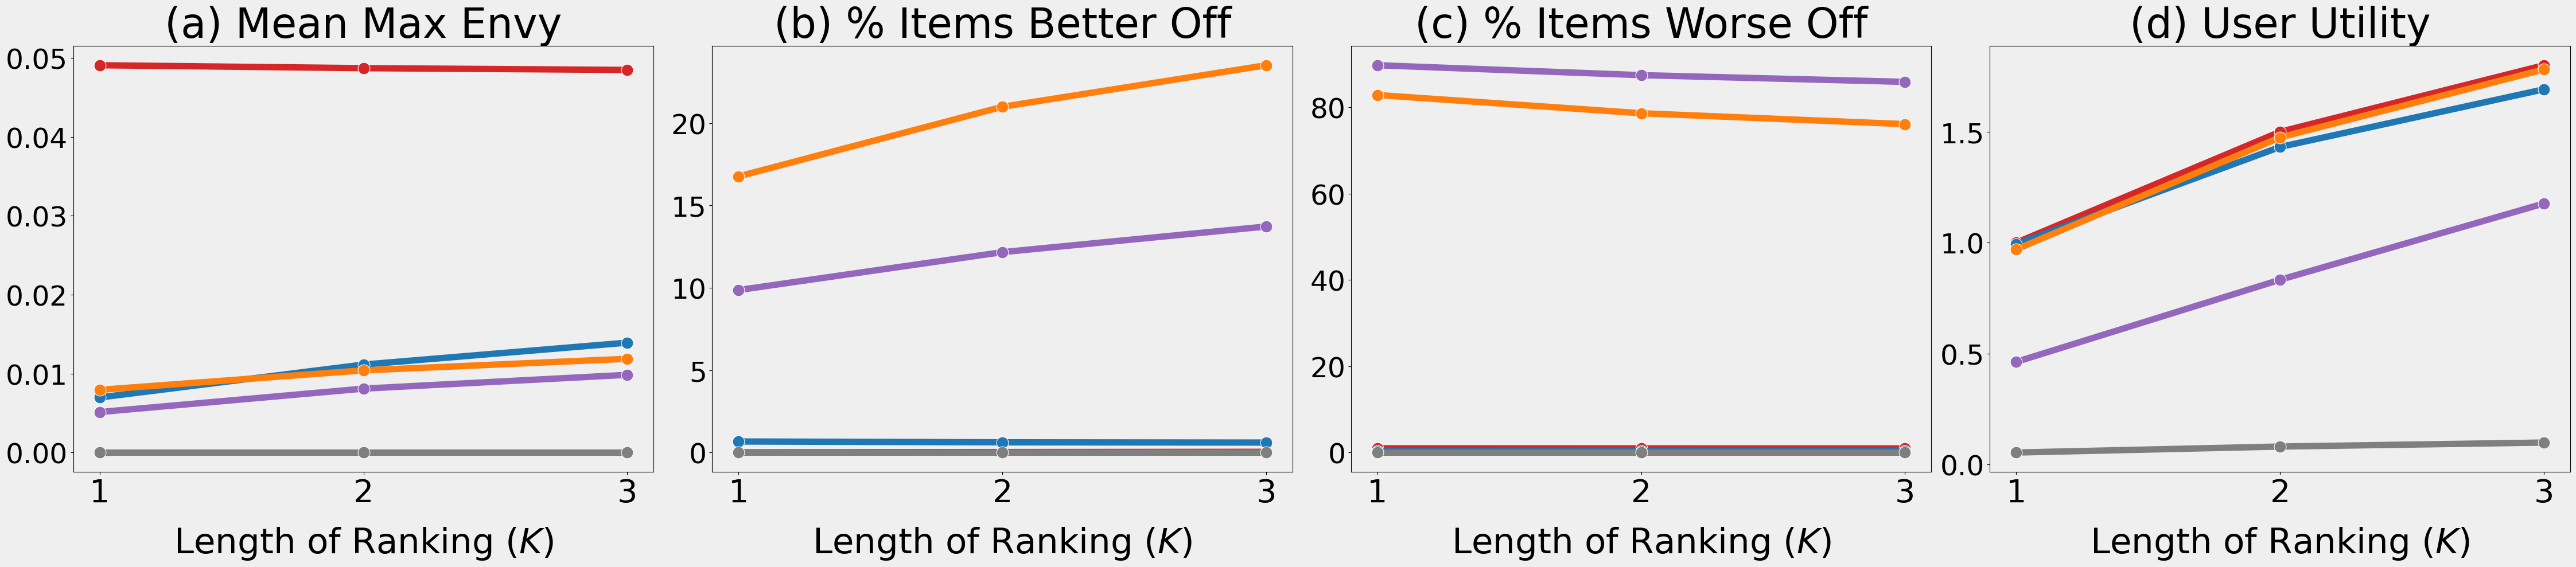

In [77]:
df = pd.read_csv("result_df.csv")
  
fig, ax = plt.subplots(1, 4, figsize=(45, 10), tight_layout=True,facecolor='#efefef')
for i, metric in enumerate(metric_list):
    ax_ = ax[i]
    sns.set_style(rc = {'axes.facecolor': '#efefef'})
    sns.lineplot(
        marker="o",
        markersize=15,
        markers=True,
        linewidth=8,
        ax=ax_,
        x="K",
        y=metric,
        hue="policy",
        legend=False,
        palette=palette,
        data=df,
    )
    ax_.set_title(title_dict[metric], fontsize=52)
    ax_.set_ylabel("")
    ax_.tick_params(axis="y", labelsize=35)
    ax_.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax_.set_xticks([1,2, 3])
    ax_.set_xlabel(r"Length of Ranking ($K$)", fontsize=44)
    ax_.tick_params(axis="x", labelsize=40)
    ax_.xaxis.set_label_coords(0.5, -0.125)
    plt.savefig('output.png')

In [41]:
fig.savefig('result.png')

In [3]:
df_brand = pd.read_json('Alcohol_brands_preprocessed.json')
df_influ = pd.read_json('influencer_data.json_influencers_pre_processed.json')

In [4]:
likes_influ_brands = df_brand.groupby(['brand_name','influencerUsername'])['likesCount'].mean().sort_values(ascending=False)
likes_influ_brands = pd.DataFrame(likes_influ_brands).reset_index()
comments_influ_brands = df_brand.groupby(['brand_name','influencerUsername'])['commentsCount'].mean().sort_values(ascending=False)
comments_influ_brands = pd.DataFrame(comments_influ_brands).reset_index()
influ_brands_size = df_brand.groupby(['brand_name', 'influencerUsername']).size().sort_values(ascending=False)
influ_brands_size = pd.DataFrame(influ_brands_size).reset_index()

In [5]:
influ_brands_size.rename(columns={0: 'brand_post'}, inplace=True)

In [6]:
tmp_df = pd.merge(influ_brands_size, likes_influ_brands, on=['brand_name', 'influencerUsername'], how='inner')

In [7]:
df = pd.merge(tmp_df, comments_influ_brands, on=['brand_name', 'influencerUsername'], how='inner')

In [8]:
influencers = df_influ[['id', 'username', 'fullName', 'followersCount', 'avg_likes', 'avg_comments']]

In [9]:
for i in df_brand['brand_name'].unique():
    influencers[i + '_posts'] = 0
    influencers[i + '_likes'] = 0
    influencers[i + '_comments'] = 0
    influencers[i + '_rele'] = 0

In [10]:
df['likesCount'].replace(-1, 0, inplace=True)

In [11]:
for i in df['influencerUsername'].unique():
    data = df[df['influencerUsername'] == i]
    brands = data['brand_name'].tolist()
    posts = data['brand_post'].tolist()
    likes, comments = data['likesCount'].tolist(), data['commentsCount'].tolist()

    for j in range(len(brands)):
        influencers.loc[influencers['username'] == i, brands[j] + '_posts'] = posts[j]
        influencers.loc[influencers['username'] == i, brands[j] + '_likes'] = likes[j]
        influencers.loc[influencers['username'] == i, brands[j] + '_comments'] = comments[j]
        influencers.loc[influencers['username'] == i, brands[j] + '_rele'] = (likes[j] + comments[j]) / posts[j]

In [12]:
df_brand['brand_name'].unique()

array(['amrutmalt', 'greaterthangin', 'indrisinglemalt',
       'rampursinglemalt', 'oldmonkkarnataka', 'sula_vineyards',
       'pauljohnwhisky', 'hapusagin', 'bira91beer', 'kingfisherultra'],
      dtype=object)

In [13]:
df_brand['brand_name'].unique().shape

(10,)

In [14]:
def get_recommendations(brand):
    df_2 = influencers[['username', brand+'_rele', 'followersCount']]
    total_rel = df_2[brand + '_rele'].sum()
    df_2['rele'] = df_2[brand + '_rele'] / total_rel
    return df_2

In [17]:
res = get_recommendations('amrutmalt')

In [18]:
res
i = 0
for brand in df_brand['brand_name'].unique():
    i += 1
    data = get_recommendations(brand)
    new_names = {'rele': f'rele_{i}'}
    data = data.rename(columns=new_names)
    if (i == 1):
        res = data
    else :
        res = pd.concat([res, data[[f'rele_{i}']]], axis=1)

In [20]:
for i in range(1, 11):
    res[f'true_rele_{i}'] = res[f'rele_{i}'].apply(lambda x: 1 if x > 0 else 0)

In [21]:
res

,username,amrutmalt_rele,followersCount,rele_1,rele_2,rele_3,rele_4,rele_5,rele_6,rele_7,...,true_rele_1,true_rele_2,true_rele_3,true_rele_4,true_rele_5,true_rele_6,true_rele_7,true_rele_8,true_rele_9,true_rele_10
2,living_max,156.0,197,0.007537,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,1,0,0,0,0,0,0,0,0,0
3,framesby_tj,196.0,1836,0.009470,0.0,0.0,0.0,0.006381,0.000000,0.000000,...,1,0,0,0,1,0,0,0,0,0
4,drinksinternational,334.0,24926,0.016138,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,1,0,0,0,0,0,0,0,0,0
5,tabithalipkin,90.0,85214,0.004348,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,1,0,0,0,0,0,0,0,0,0
6,ninnajji,88.0,1531,0.004252,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1550,nooranandchawla,0.0,23232,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.001366,...,0,0,0,0,0,0,1,0,0,0
1551,malakaspice,0.0,5869,0.000000,0.0,0.0,0.0,0.000000,0.000899,0.000000,...,0,0,0,0,0,1,0,0,0,0
1552,salimsulaimanmusic,0.0,132248,0.000000,0.0,0.0,0.0,0.000000,0.001171,0.000000,...,0,0,0,0,0,1,0,0,0,0
1554,isha_konnects,0.0,1116292,0.000000,0.0,0.0,0.0,0.000000,0.000543,0.000000,...,0,0,0,0,0,1,0,0,0,0
